# Non stationary Ornstein Uhlenbeck in 2D (Fokker-Planck Equation) with RAR sampling

We want to estimate the solution $u(t,\mathbf{x})$ of

$$
-\sum_{i=1}^2\frac{\partial}{\partial \mathbf{x}}
         \left[(\alpha(\mu - \mathbf{x}))u(t,\mathbf{x})\right] +
         \sum_{i=1}^2\sum_{j=1}^2\frac{\partial^2}{\partial x_i \partial x_j}              
         \left[\frac{\sigma^2}{2}u(t,\mathbf{x})\right]=                                   
         \frac{\partial}
         {\partial t}u(t,\mathbf{x})
 $$

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

Float64 and GPU settings

In [2]:
#import os; os.environ["JAX_ENABLE_X64"] = "TRUE" # comment/uncomment to  disable/enable float64 for JAX
#import os; os.environ["CUDA_VISIBLE_DEVICES"]="" # If uncommented then GPU is disable

Import our package

In [3]:
import jinns

Import other dependencies

In [4]:
import jax
from jax import random, vmap
import jax.numpy as jnp
import equinox as eqx
from functools import partial

import matplotlib.pyplot as plt

key = random.PRNGKey(2)
key, subkey = random.split(key)

Create the neural network architecture for the PINN with `equinox`. Note that we will use the same architecture for the 3 populations.

In [5]:
eqx_list = [
    [eqx.nn.Linear, 3, 30],
    [jax.nn.tanh],
    [eqx.nn.Linear, 30, 30],
    [jax.nn.tanh],
    [eqx.nn.Linear, 30, 30],
    [jax.nn.tanh],
    [eqx.nn.Linear, 30, 1],
    [jnp.exp]
]
key, subkey = random.split(key)
init_param_fn, u = jinns.utils.create_PINN(subkey, eqx_list, "nonstatio_PDE", 2)

Below is an example how to create the PINN whithout the utility function

In [6]:
# class MLP(eqx.Module):
#     layers: list

#     def __init__(self, key):
#         key1, key2, key3, key4 = jax.random.split(key, 4)

#         self.layers = [
#             jnp.ravel,
#             eqx.nn.Linear(3, 30, key=key1),
#             jax.nn.tanh,
#             eqx.nn.Linear(30, 30, key=key2),
#             jax.nn.tanh,
#             eqx.nn.Linear(30, 30, key=key3),
#             jax.nn.tanh,
#             eqx.nn.Linear(30, 1, key=key4),
#             jnp.exp,
#         ]

#     def __call__(self, x):
#         for layer in self.layers:
#             x = layer(x)
#         return x

# def make_mlp(key):
#     mlp = MLP(key)  # insert your model here
#     params, static = eqx.partition(mlp, eqx.is_inexact_array)

#     def init_fn():
#         return params

#     def apply_fn(t, x, u_params, eq_params=None):
#         t_x = jnp.concatenate([t, x], axis=-1)
#         model = eqx.combine(u_params, static)
#         return model(t_x)[0]

#     return init_fn, apply_fn

Create the DataGenerator object

In [7]:
n = 500
nb = 4 # not used here
nt = 500
omega_batch_size = 32
omega_border_batch_size = None # not used here
temporal_batch_size = 20
xmin = -3
xmax = 3
ymin = -3
ymax = 3
tmin = 0
tmax = 1
method="uniform"

# Residual Adaptative Refinement
rar_parameters = {
    'start_iter':1000,
    'update_rate':500,
    'sample_size':500, # No cartesian product is taken in dynamic losses of Non Statio PDE in RAR loss eval
    'selected_sample_size':5,
    'iter_from_last_sampling':0,
    'iter_nb':0
}
n_start = 200

key, subkey = random.split(key)
train_data = jinns.data.CubicMeshPDENonStatio(
    subkey,
    n,
    nb,
    nt,
    omega_batch_size,
    omega_border_batch_size,
    temporal_batch_size,
    2,
    (xmin, ymin),
    (xmax, ymax),
    tmin,
    tmax,
    method=method,
    rar_parameters=rar_parameters,
    n_start=n_start
)

Initialize the PINN parameters and visualize the PINN output before training

In [8]:
init_nn_params = init_param_fn()

In [9]:
vectorized_u_init = vmap(partial(u, u_params=init_nn_params), (0, 0), 0)

## Model parameters

In [10]:
# true solution N(0,1)
sigma = 0.5 * jnp.ones((2))
alpha = .5 * jnp.ones((2))
mu = jnp.zeros((2))

Tmax = 5

In our problem we know the analytical stationary solution

In [11]:
from jax.scipy.stats import multivariate_normal

def u_statio(x):
    return multivariate_normal.pdf(x, mean=mu, cov=jnp.diag((sigma/jnp.sqrt(2*alpha)) ** 2))

vectorized_u_statio = vmap(u_statio, (0), 0)

In [12]:
init_params = {
    "nn_params":init_nn_params,
    "eq_params":{
        "sigma":sigma,
        "alpha":alpha,
        "mu":mu
    }
}

## Set up the initial condition

In [13]:
# Initial law at t=0 
u0 = u_statio

# Another init
# TODO : implement other init
def u0(x):
    return multivariate_normal.pdf(x, mean=jnp.array([1, 1]), cov=0.1 * jnp.eye(2))

vectorized_u0 = vmap(u0, (0), 0)

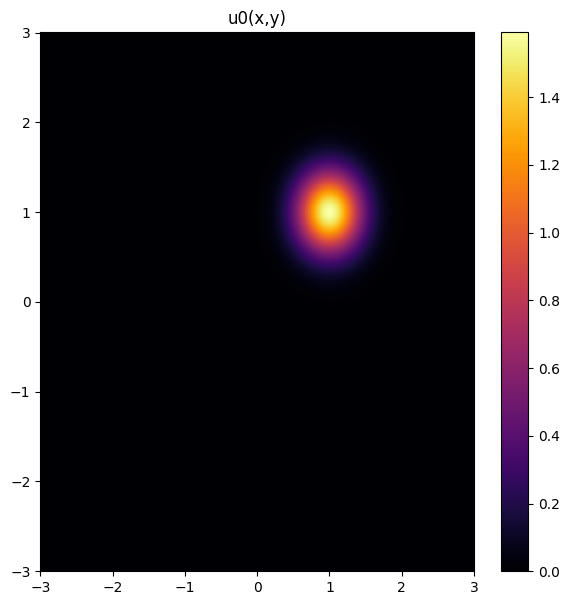

In [14]:
nx, ny = 1000, 1000
val_xy_data = [jnp.linspace(xmin, xmax, nx),
               jnp.linspace(ymin, ymax, ny)
              ]

jinns.data.plot2d(
    fun=u0,
    xy_data=val_xy_data,
    title="u0(x,y)"
)

## Loss construction

We decide to provide the set of points upon which the normalization constant will be computed

In [15]:
int_xmin, int_xmax = -5, 5
int_ymin, int_ymax = -5, 5

n_samples = int(1e3)
int_length = (int_xmax - int_xmin) * (int_ymax - int_ymin)
key, subkey1, subkey2 = random.split(key, 3)
mc_samples = jnp.concatenate(
    [
        random.uniform(
            subkey1, shape = (1000, 1), minval=int_xmin, maxval=int_xmax
        ),
        random.uniform(
            subkey2, shape = (1000, 1), minval=int_ymin, maxval=int_ymax
        )
    ],
    axis=-1
)

In [16]:
OU_fpe_non_statio_2D_loss = jinns.loss.OU_FPENonStatioLoss2D(Tmax=Tmax)

In [17]:
loss_weights = {"dyn_loss":1, "temporal_loss":1 * Tmax, "norm_loss":0.001 * Tmax}

loss = jinns.loss.LossPDENonStatio(
    u=u,
    loss_weights=loss_weights,
    dynamic_loss=OU_fpe_non_statio_2D_loss,
    temporal_boundary_fun=u0,
    norm_borders=((int_xmin, int_xmax), (int_ymin, int_ymax)),
    norm_samples=mc_samples
)

/home/hugo/Documents/recherche/pinn/gitlab/jinns/loss/_LossPDE.py:284: UserWarning: Missing boundary function or no boundary condition.Boundary function is thus ignored.
  warnings.warn(


In [18]:
losses_and_grad = jax.value_and_grad(loss.evaluate, 0, has_aux=True)
losses, grads = losses_and_grad(
    init_params,
    batch = train_data.get_batch()
)


l_tot, d = losses
print(f"total loss: {l_tot:.2f}")
print(f"Individual losses: { {key: f'{val:.2f}' for key, val in d.items()} }")

total loss: 105.79
Individual losses: {'boundary_loss': '0.00', 'dyn_loss': '33.69', 'norm_loss': '13103.52', 'observations': '0.00', 'temporal_loss': '1.32'}


## Learning the neural network parameters
The learning process here consider known equation parameters `eq_params`. We thus only update `nn_params`

In [19]:
params = init_params

In [20]:
# Optimizer
import optax
from jaxopt import OptaxSolver


tx = optax.adam(learning_rate=1e-3)
solver = OptaxSolver(opt=tx, fun=loss,
                     has_aux=True, # because the objective has aux output
                     maxiter=50000)


In [21]:
n_iter = int(20000)
pinn_solver = jinns.solver.PinnSolver(
    optax_solver=solver,
    loss=loss,
    n_iter=n_iter
)

In [22]:
params = init_params

We are performing RAR sampling scheme, let's see the distribution fo the collocation points before the start of the training.

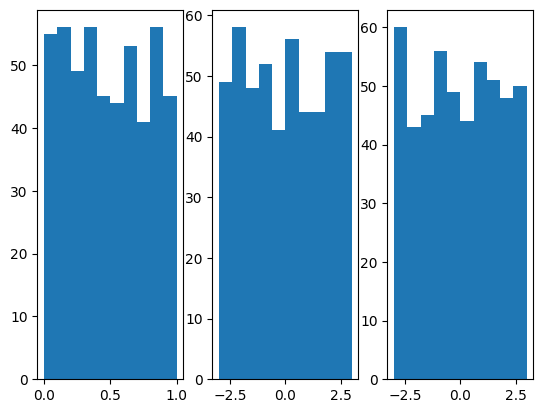

In [23]:
fig, ax = plt.subplots(1, 3)
ax[0].hist(train_data.times)
ax[1].hist(train_data.omega[:, 0].flatten())
ax[2].hist(train_data.omega[:, 1].flatten())
plt.show()

In [24]:
times_before = train_data.times.copy()
times_before[:10]

Array([0.37506747, 0.64363277, 0.5080061 , 0.7978177 , 0.28878248,
       0.74769473, 0.05265486, 0.98085713, 0.05796266, 0.7920381 ],      dtype=float32)

In [25]:
key, subkey = random.split(key, 2)
params, total_loss_list, loss_by_term_dict, train_data, _, _ = pinn_solver.solve(
    init_params=params,
    data=train_data
)

/home/hugo/Documents/recherche/pinn/gitlab/jinns/loss/_LossPDE.py:284: UserWarning: Missing boundary function or no boundary condition.Boundary function is thus ignored.
  warnings.warn(


  0%|          | 0/20000 [00:00<?, ?it/s]

In the next figure, we see the distribution fo the collocation points after the end of the training. We see that the new points are preferentially added at $t=0$, on the borders and around the origin in the upper right quadrant. This could be expected since we expected that those are the collocation points where most things actually happen.

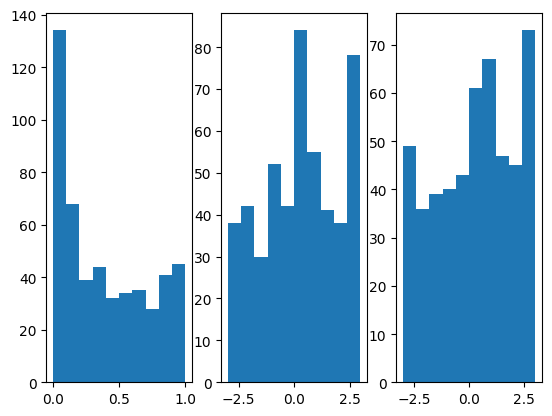

In [26]:
fig, ax = plt.subplots(1, 3)
ax[0].hist(train_data.times)
ax[1].hist(train_data.omega[:, 0].flatten())
ax[2].hist(train_data.omega[:, 1].flatten())
plt.show()

## Results

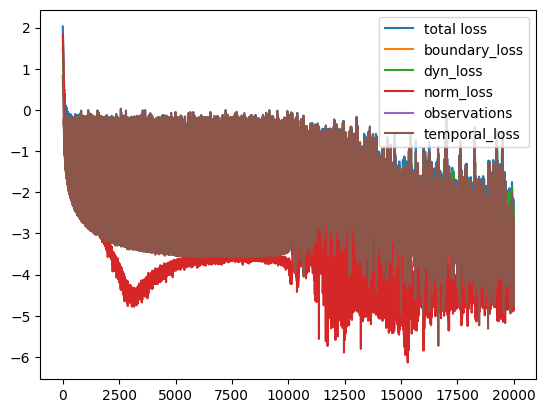

In [28]:
plt.plot(jnp.log10(total_loss_list), label="total loss")
for loss_name, loss_values in loss_by_term_dict.items():
    plt.plot(jnp.log10(loss_weights[loss_name] * loss_values), label=loss_name)
plt.legend()
plt.show();

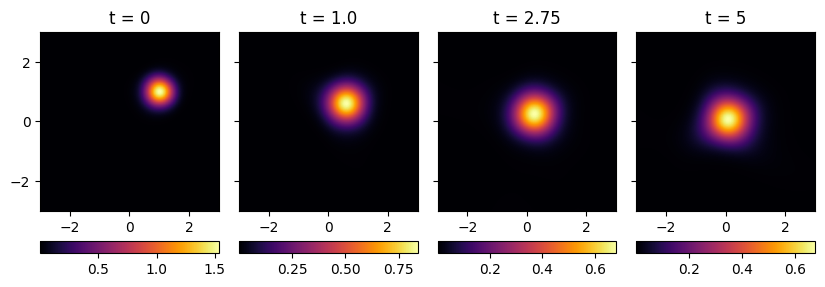

In [29]:
times = [0, 0.2, 0.55, 1] # times in the rescaled time susescale
u_est = partial(u, u_params=params["nn_params"])

jinns.data.plot2d(
    fun=u_est,
    xy_data=val_xy_data,
    times = times,
    Tmax=Tmax,
    title="u0(x,y)",
    figsize=(10, 10*len(times))
)

__Conclusion on RAR sampling:__ We can see that given 20000 iterations and the RAR sampling scheme defined above we ended up with a better result than with a standard and fixed uniform sampling of collocation points. Indeed, we performed the experiment and obtained the following final figure, where intensities and shape are not well determined:

![fig](2d_nonstatio_ou_standardsampling.png)

Therefore, given the same number of iterations and a total number of collocation points equal to the final number of collocation points at the end of RAR sampling, we here see the advantage of RAR sampling. This figure can be reproduced by simply setting `rar_parameters=None` at the data generator creation at the beginning of the notebook. Note that the standard and fixed uniform sampling of collocation points can also give good results in this experiment by setting a bigger number of iterations or bigger number of collocation points.